# Implementation of Deep Convolutional GAN (DCGAN)

In this notebook we implement the Deep Convolutional Generative Adversarial Network (DCGAN). We generate numbers based on MNIST dataset.


In [35]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

# GAN Generator

The generator converts a vector of random numbers (input) into an image in the output. In order to convert the input ($z$) to the output the input vector must pass through several generator blocks (GB). Each generator block is composed by a upsampling layer that uses fractionally strided convolutions (also referred to as deconvolutions), and an activation function (`ReLU` or `Tanh`). All layers before the last layer also have a layer to perform batch normalization. As described in the [original paper](https://arxiv.org/pdf/1511.06434.pdf):

- Replace any pooling layers with fractional-strided convolutions (generator).
- Use `batchnorm` in both the generator and the discriminator
- Use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`

<img src="images/generator.svg" width="40%"/>

In [31]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, img_channels=1, hidden_dim=64):
        """
        Parameters:
        -----------
        z_dim: int
            Dimension of the noise vector
        img_channels: int
            Number of channels of the image
        hidden_dim: int
            Dimension of the hidden layer
        """
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.GB(z_dim, hidden_dim*4, kernel_size=3, stride=2),
            self.GB(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.GB(hidden_dim*2, hidden_dim, kernel_size=3, stride=2),
            self.GB(hidden_dim, img_channels, kernel_size=4, stride=2, output_layer=True)
        )
        
        
    def GB(self, ch_input, ch_output, kernel_size=3, stride=2, output_layer=False):
        """Create a generative block.
        
        Parameters:
        -----------
        ch_input: int
            Number of channels of the input
        ch_output: int
            Number of channels of the output
        kernel_size: int
            Size of the kernel (squared kernel)
        stride: int
            Stride of the transposed convolution
        output_layer: boolean
            True in case it is the last layer
        """
        if output_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(ch_input, ch_output, kernel_size, stride=stride),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(ch_input, ch_output, kernel_size, stride=stride),
                nn.BatchNorm2d(ch_output),
                nn.ReLU()
            )
        
    
    def forward(self, noise_vector):
        """Perform the forward pass in the generator
        
        Parameters:
        -----------
        noise_vector: array
            Vector of shape (batch_size, z_dim, 1, 1)
        """
        return self.gen(noise_vector)

In [27]:
def generate_noise_vector(batch_size, z_dim):
    """Generate noise vectors."""
    noise = torch.randn(batch_size, z_dim)
    return noise.view(len(noise), z_dim, 1, 1)

In [28]:
print(Generator())
print('Noise vector: {}'.format(generate_noise_vector(2,10).shape))

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(10, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)
Noise vector: torch.Size([2, 10, 1, 1])


# GAN Discriminator

Unlike the Geneator that intends to create an image from a noise vector, the discriminator intends to learn how to differentiate a real image from a fake image created by the generator. To do so, it receives an image as input and through a set of convolutions extract features to classify the image as real or fake. According to the original paper, we should follow a couple of steps.

- Replace any pooling layers with strided convolutions (discriminator);
- Use `batchnorm` in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use `LeakyReLU` activation in the discriminator for all layers.
- In the `LeakyReLU`, the slope of the leak should be set to 0.2

<img src="images/discriminator.svg" width="40%"/>

In [29]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=1, hidden_dim=64, batch_size=128):
        """
        Parameters:
        -----------
        img_channels: int
            Number of channels of the image
        hidden_dim: int
            Dimension of the hidden layer
        """
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.DB(img_channels, hidden_dim),
            self.DB(hidden_dim, hidden_dim*2),
            self.DB(hidden_dim*2, 1, output_layer=True)
        )
        
    def DB(self, ch_input, ch_output, kernel_size=3, stride=2, output_layer=False):
        """Create a generative block.
        
        Parameters:
        -----------
        ch_input: int
            Number of channels of the input
        ch_output: int
            Number of channels of the output
        kernel_size: int
            Size of the kernel (squared kernel)
        stride: int
            Stride of the transposed convolution
        output_layer: boolean
            True in case it is the last layer
        """
        if output_layer:
            return nn.Sequential(
                nn.Conv2d(ch_input, ch_output, kernel_size, stride=stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_input, ch_output, kernel_size, stride=stride),
                nn.BatchNorm2d(ch_output),
                nn.LeakyReLU(negative_slope=0.2)
            )
        
    def forward(self, image):
        """Perform the forward pass in the discriminator.
        
        Parameters:
        -----------
        image: array
            Image of shape (batch_size, nb_channels, width, height)
            
        Returns:
        --------
        pred: array
            A 1-dimensional vector representing real/fake image
        """
        pred = self.disc(image)
        return pred.view(len(pred), -1)

In [30]:
Discriminator()

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2))
    )
  )
)

# Setting up DCGAN

DCGAN uses the Binary Cross Entropy as loss function. As described in the original paper:

> No pre-processing was applied to training images besides scaling to the range of the tanh activation
function `[-1, 1]` (`normalize_images`). All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128 (`batch_size=128`). All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02 (`initialize_weights()`). While previous GAN work has used momentum to accelerate training, we used the Adam optimizer (`gen_opt` and `disc_opt`) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 (`lr=0.0002`) instead. Additionally, we found leaving the momentum term $\beta_1$ at the
suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 (`beta_1=0.5`) helped stabilize training.


In [50]:
def initialize_weights(w):
    """Initialize weights of layers.
    
    w: array
        Matrix of weights from a conv or batchnorm layer
    """
    if isinstance(w, nn.Conv2d) or isinstance(w, nn.ConvTranspose2d):
        torch.nn.init.normal_(w.weight, 0.0, 0.02)
    elif isinstance(w, nn.BatchNorm2d):
        torch.nn.init.normal_(w.weight, 0.0, 0.02)
        torch.nn.init.constant_(w.bias, 0)
        

# Convert image to a range between [-1, 1] due to Tanh function.
normalize_images = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

criterion = nn.BCEWithLogitsLoss()
z_dim = 64
lr = 0.0002
batch_size = 128
beta_1 = 0.5
beta_2 = 0.999

gen = Generator(z_dim)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
gen.apply(initialize_weights)

disc = Discriminator()
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
disc.apply(initialize_weights)

data = DataLoader(
    MNIST('.', download=False, transform=normalize_images),
    batch_size = batch_size,
    shuffle = True
)

In [51]:
# Show image
from torchvision.utils import make_grid

def show_image(img_tensor, batch_size=25, size_imgs=(1,28,28)):
    """Show an image from the batch."""
    img_tensor = (img_tensor + 1)/2
    img_unflat = img_tensor.detach()
    img_grid = make_grid(img_unflat[:batch_size], nrow=5)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

# Training DCGAN

## Training discriminator

<img src="images/train_discriminator.svg" width="90%"/>

## Training generator

<img src="images/train_generator.svg" width="90%"/>

Step: 0 GEN loss: 0.0013778257369995118 DISC loss: 0.0013844363689422608


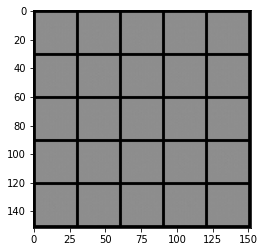

Step: 500 GEN loss: 1.2521000320911408 DISC loss: 0.3969242758154869


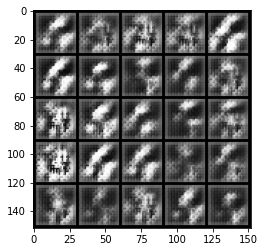

Step: 1000 GEN loss: 1.1491498501300812 DISC loss: 0.4985553287267685


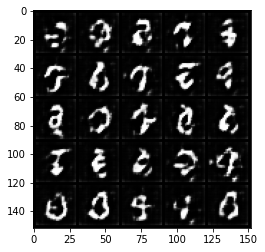

Step: 1500 GEN loss: 0.825965016245842 DISC loss: 0.6211332960128784


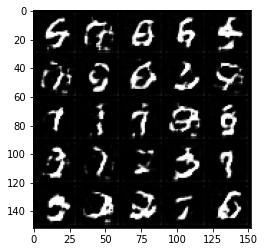

Step: 2000 GEN loss: 0.8103503667116165 DISC loss: 0.633854465842247


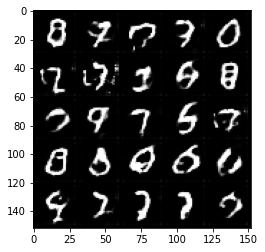

Step: 2500 GEN loss: 0.8114075232744217 DISC loss: 0.6369784367084503


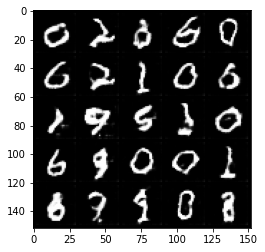

Step: 3000 GEN loss: 0.811624320268631 DISC loss: 0.6385675616264344


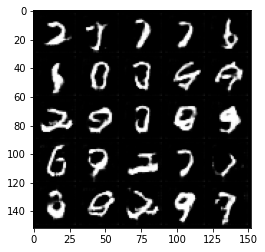

Step: 3500 GEN loss: 0.8076671766042709 DISC loss: 0.6429501321315766


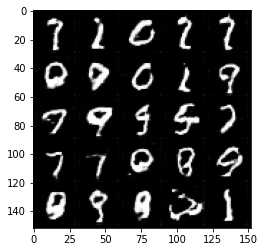

Step: 4000 GEN loss: 0.802146565914154 DISC loss: 0.6481068959236145


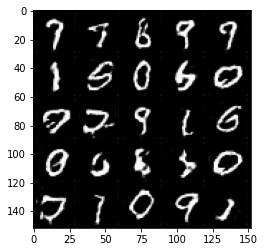

Step: 4500 GEN loss: 0.8034115391969681 DISC loss: 0.6479899762868881


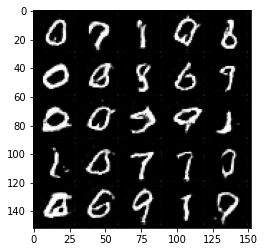

In [53]:
# Train network
epochs = 10
step = 0
mean_step = 500
mean_gen_loss = 0
mean_disc_loss = 0

for e in range(epochs):
    for image, _ in data:
        sample_size = len(image)
        
        # Discriminator
        disc_opt.zero_grad()
        noise_vec = generate_noise_vector(sample_size, z_dim)
        fake_image = gen(noise_vec)

        pred_fake = disc(fake_image.detach())
        disc_fake_loss = criterion(pred_fake, torch.zeros_like(pred_fake))
        
        pred_real = disc(image)
        disc_real_loss = criterion(pred_real, torch.ones_like(pred_real))
        disc_loss = (disc_fake_loss + disc_real_loss)/2
        mean_disc_loss += disc_loss.item()
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # Generator
        gen_opt.zero_grad()
        noise_vec = generate_noise_vector(sample_size, z_dim)
        fake_image = gen(noise_vec)

        pred_fake = disc(fake_image)
        gen_loss = criterion(pred_fake, torch.ones_like(pred_fake))
        gen_loss.backward()
        gen_opt.step()
        mean_gen_loss += gen_loss.item()
        
        if step % mean_step == 0:
            print('Step: {} GEN loss: {} DISC loss: {}'.format(step, 
                                                               mean_gen_loss/mean_step, 
                                                               mean_disc_loss/mean_step))
            show_image(fake_image)
            mean_gen_loss = 0
            mean_disc_loss = 0
        step += 1